# PyPSA Validation

In this notebook, we show how to import and export from PyPSA and verify that both PyPSA and Zap produce the same results.

In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import zap
import pypsa
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

from zap.tests import network_examples as examples

## Import a network

First, we will import a network into zap and verify that the inputs remain unchanged.

In [68]:
pn = examples.load_example_network('texas_7node')

INFO:pypsa.io:Imported network texas_7node.nc has buses, carriers, generators, lines, loads, storage_units


In [94]:
net, devices = zap.importers.load_pypsa_network(pn, verbose=True, use_active_only=False, susceptance_unit=1.0)

INFO:zap.importers.pypsa:Importing Generator with 176 devices.
INFO:zap.importers.pypsa:Importing Load with 7 devices.
INFO:zap.importers.pypsa:Importing ACLine with 12 devices.
INFO:zap.importers.pypsa:Importing StorageUnit with 14 devices.


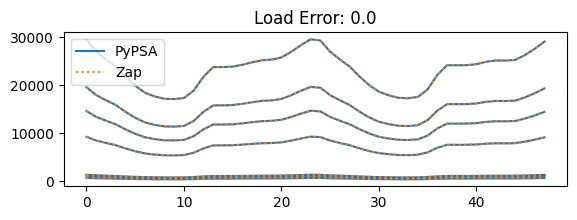

In [24]:
load_device = [d for d in devices if isinstance(d, zap.Load)][0]
num_loads = load_device.num_devices

pypsa_loads = pn.loads_t["p_set"].values
zap_loads = (load_device.load * load_device.nominal_capacity).T

fig, ax = plt.subplots(figsize=(6.5, 2))

ax.set_title(f"Load Error: {np.sum(np.abs(pypsa_loads - zap_loads))}")
ax.plot(pypsa_loads, c="C0", label=["PyPSA"] + [""]*(num_loads-1))
ax.plot(zap_loads, ls=":", c="C1", label=["Zap"] + [""]*(num_loads-1))
ax.legend()

plt.show()

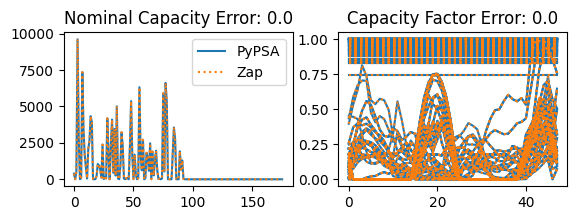

In [77]:
# Plot generator nominal capacities and capacity factors
gen_device = [d for d in devices if isinstance(d, zap.Generator)][0]
num_gens = gen_device.num_devices

pypsa_capacity_factor = pn.get_switchable_as_dense("Generator", "p_max_pu").values
pypsa_nominal_capacities = pn.generators.p_nom.values
zap_capacity_factors = gen_device.max_power.T
zap_nominal_capacities = gen_device.nominal_capacity.reshape(-1)

fig, axes = plt.subplots(1, 2, figsize=(6.5, 2))

ax = axes[0]
ax.set_title(f"Nominal Capacity Error: {np.sum(np.abs(pypsa_nominal_capacities - zap_nominal_capacities))}")
ax.plot(pypsa_nominal_capacities, label="PyPSA")
ax.plot(zap_nominal_capacities, ls=":", label="Zap")
ax.legend()

ax = axes[1]
ax.set_title(f"Capacity Factor Error: {np.sum(np.abs(pypsa_capacity_factor - zap_capacity_factors))}")
ax.plot(pypsa_capacity_factor, c="C0")
ax.plot(zap_capacity_factors, ls=":", c="C1")

plt.show()

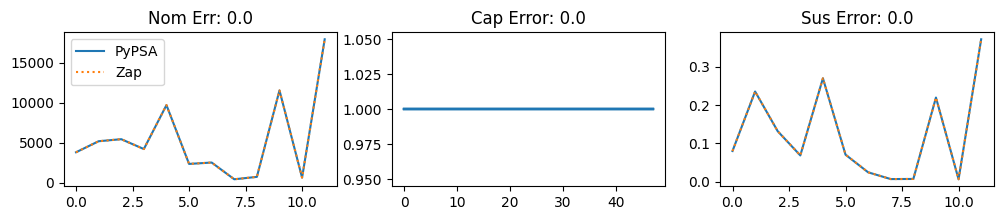

In [111]:
# Plot AC line parameters
ac_device = [d for d in devices if isinstance(d, zap.ACLine)][0]
num_links = ac_device.num_devices

pypsa_nom_cap = pn.lines.s_nom.values
pypsa_cap_fac = pn.get_switchable_as_dense("Line", "s_max_pu").values
pypsa_sus = 1 / pn.lines.x.values

zap_nom_cap = ac_device.nominal_capacity.reshape(-1)
zap_cap_fac = ac_device.capacity.T
zap_sus = ac_device.susceptance.reshape(-1) * zap_nom_cap / 1e3

fig, axes = plt.subplots(1, 3, figsize=(12, 2))

ax = axes[0]
ax.set_title(f"Nom Err: {np.sum(np.abs(pypsa_nom_cap - zap_nom_cap))}")
ax.plot(pypsa_nom_cap, label="PyPSA")
ax.plot(zap_nom_cap, ls=":", label="Zap")
ax.legend()

ax = axes[1]
ax.set_title(f"Cap Error: {np.sum(np.abs(pypsa_cap_fac - zap_cap_fac))}")
ax.plot(pypsa_cap_fac, c="C0")
ax.plot(zap_cap_fac, ls=":", c="C1")

ax = axes[2]
ax.set_title(f"Sus Error: {np.round(np.sum(np.abs(pypsa_sus - zap_sus)), decimals=8)}")
ax.plot(pypsa_sus)
ax.plot(zap_sus, ls=":")

plt.show()

In [82]:
# # Plot DC line parameters
# dc_device = [d for d in devices if isinstance(d, zap.DCLine)][0]
# num_links = dc_device.num_devices

# pypsa_nom_cap = pn.links.p_nom.values
# pypsa_cap_fac = pn.get_switchable_as_dense("Link", "p_max_pu").values

# zap_nom_cap = dc_device.nominal_capacity.reshape(-1)
# zap_cap_fac = dc_device.capacity.T

# fig, axes = plt.subplots(1, 2, figsize=(6.5, 2))

# ax = axes[0]
# ax.set_title(f"Nom Capacity Error: {np.sum(np.abs(pypsa_nom_cap - zap_nom_cap))}")
# ax.plot(pypsa_nom_cap, label="PyPSA")
# ax.plot(zap_nom_cap, ls=":", label="Zap")
# ax.legend()

# ax = axes[1]
# ax.set_title(f"Capacity Factor Error: {np.sum(np.abs(pypsa_cap_fac - zap_cap_fac))}")
# ax.plot(pypsa_cap_fac, c="C0")
# ax.plot(zap_cap_fac, ls=":", c="C1")

# plt.show()

## Solve operations in Zap and check results

In [12]:
results = net.dispatch(devices=devices, time_horizon=48, solver=cp.CLARABEL)

In [13]:
device_index = 0
results.power[0][0].shape

(136, 48)

In [14]:
zap_pypsa = zap.exporters.export_to_pypsa(net, devices, results, snapshots=pn.snapshots)
zap_pypsa

/Users/degleris/Documents/code/zap/zap/exporters/pypsa.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  n.generators_t[attr][name] = df.loc[name]
/Users/degleris/Documents/code/zap/zap/exporters/pypsa.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  n.generators_t[attr][name] = df.loc[name]
/Users/degleris/Documents/code/zap/zap/exporters/pypsa.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

PyPSA Network
Components:
 - Bus: 7
 - Generator: 136
 - Line: 12
 - Load: 7
 - StorageUnit: 14
Snapshots: 48

In [112]:
# zap_pypsa.buses_t.marginal_price